# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [6]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [7]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [35]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
#   movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['excl_count'] = movie_data['review'].str.count("!!!")

    X_quant_features = movie_data[["excl_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [36]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=12)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   excl_count  punc_count
0           0          20
1           0          16
2           0          20
3           0           8
4           0           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [37]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 4641, 'TN': 5625, 'FP': 4427, 'FN': 5307, 'Accuracy': 0.5133, 'Precision': 0.5117997353330392, 'Recall': 0.46652593486127863, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [43]:
from sklearn import linear_model
# alpha 0.0001 to 0.003
svm = linear_model.SGDClassifier(alpha=0.003)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9947, 'TN': 10051, 'FP': 1, 'FN': 1, 'Accuracy': 0.9999, 'Precision': 0.9998994772818657, 'Recall': 0.9998994772818657, 'desc': 'svm_train'}


### MODEL: logistic regression

In [44]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9948, 'TN': 10052, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB
# alpha value to 3.0 from 1.0
nbs = MultinomialNB(alpha=3.0)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9546, 'TN': 9883, 'FP': 169, 'FN': 402, 'Accuracy': 0.97145, 'Precision': 0.9826042202779207, 'Recall': 0.9595898673100121, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [46]:
from sklearn import linear_model
# penalty model to l1 from l2. max_iter 1500 from 1000
prc = linear_model.SGDClassifier(loss='perceptron',penalty='l1',max_iter=1500)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9945, 'TN': 10047, 'FP': 5, 'FN': 3, 'Accuracy': 0.9996, 'Precision': 0.9994974874371859, 'Recall': 0.9996984318455971, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [45]:
from sklearn import linear_model
# tolerance 0.001 to 0.01
rdg = linear_model.RidgeClassifier(alpha=8.0,tol=0.01)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 9922, 'TN': 10028, 'FP': 24, 'FN': 26, 'Accuracy': 0.9975, 'Precision': 0.9975869696360345, 'Recall': 0.9973864093285082, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
# depth 4 from 2, estimator 300 from 100
rdf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=300)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9948, 'Neg': 10052, 'TP': 8184, 'TN': 8693, 'FP': 1359, 'FN': 1764, 'Accuracy': 0.84385, 'Precision': 0.8575919522162841, 'Recall': 0.8226779252110977, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

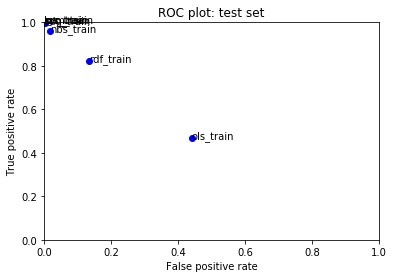

In [48]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [18]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [19]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
12
The Brothers Quay are directors, judging by conventional thought, should have stuck to making short films. I myself actually really liked their first feature, Institute Benjamenta, but judging by their sophomore effort, The Piano Tuner of Earthquakes, I'm willing to agree they don't come close to equaling their past genius at feature length. Piano Tuner is, without a doubt, a gorgeous film to look at, and often to listen to. Unfortunately, it's borderline painful to sit through with its convoluted narrative and glacial pace. Reading the plot synopsis, it sounds like a pretty good story. But the Brothers fail miserably to bring it to life. One thing they should consider avoiding completely in the future: dialogue. My God, it's awful here. A huge bust.
* * * * * * * * * 
31
you can be fooled by your first impressions. as in, initial reactions to a movie, for example. as in, the first time i saw this movie i was bedazzled by the idea of it (first of all, i 

1882
Considering its pedigree, this should be a far more enjoyable film than it is. Even with a lip-smacking collection of eccentrics in the cast - what aficionado would not eagerly anticipate a movie which brings together Lemmon, Lanchester, Kovacs and Gingold? - the entire event is dully paced, drearily shot and, more often than not, witless.<br /><br />Kim Novak's gifts were not essentially comic, as she went on to confirm in Kiss Me Stupid. James Stewart was a fine comedian, as he ably demonstrated in movies from ranging from The Philadelphia Story to Harvey. I think he comes out better from this mess than anyone else does. Except maybe the cat.
* * * * * * * * * 
1914
Incredibly muddled, off-putting and ultimately ludicrous (\the horses, oh my God, the horses!\") thriller. It's creepy at times, but it has one of the worst scripts ever written for a horror film. Watch how in the final 10 minutes everybody \"magically\" does exactly what the plot needs for the \"resolution\" to occu

4229
<br /><br />Get your brewskies out and enjoy this flawed action flick. Speakman's considerable kempo skill (nice spin kicks, decent with the sticks - poor couch!) is the only redeeming quality of a movie that just cries bad acting. The plot isn't half bad; just executed pretty poorly. But if you're seeing this movie for anything other than martial arts, you're missing the boat entirely. And for a movie that is supposed to take place in Koreatown, way way too few Korean actors (even extras).
* * * * * * * * * 
4283
Alone in The Dark is one of my favorite role-playing-games of all time. I remember spending whole nights facing the PC screen, trying to escape that mansion and actually being startled at times when monsters came surprisingly charging in. Now, mind you - I am weary of \computer-game-generated\" movies. I don't remember a single success story in this new Hollywood genre, although some are entertaining enough to be watchable. And yet, I am such a big fan of the game that I

7015
What a terrible movie. The acting was bad, the pacing was bad, the cinematography was bad, the directing was bad, the \special\" effects were bad. You expect a certain degree of badness in a slasher, but even the killings were bad.<br /><br />First of all, the past event that set up the motive for the slaughter went on for 15 or 20 minutes. I thought it would never end. They could have removed 80% of it and explained what happened well enough.<br /><br />Then, the victims were invited to the \"reunion\" in an abandoned school which still had all the utilities turned on. One of the victims thought this was a little odd, but they dismissed it and decided to break in anyway.<br /><br />Finally, the killings were so fake as to be virtually unwatchable.<br /><br />There is no reason to watch this movie, unless you want to see some breasts, and not very good breasts at that. This movie makes Showgirls virtually indistinguishable from Citizen Kane."
* * * * * * * * * 
7112
I watched this

9935
Rosie wasted a lot of TV time talking about the Tainos as if they were super influential in the dynamics of the modern day Puerto Rican. They were not. The truth is that the Africans and the Spanish were and she knows it. What kills me is that she is standing on the screen looking like some average light skin black chick ( with an obvious black daddy, cousins and auntie)pretending to truly acknowledge the real essence of what makes them the modern day Puerto Ricans,but barely mentioned how Africans influenced the way their Spanish is spoken, the food and music. She is so typical and I lost a lot of respect for her and will not support anything else she does. Also, since she wants to dance around her African-ness then she need not take more roles associated with blackness (i.e. Lackawanna Blues). We can find a prideful Black Latina next time (thank you Zoe Saldana,Gina Torres, Gina Ravera and Melissa DeSousa).<br /><br />To the Puerto Rican on here that said they are African and no

12614
Why did I waste my time with this movie? There was not a single funny joke or line throughout. The slapstick wasn't even mildly funny. I mean really, an out of control vacuum sucking pipe? Why has the National Lampoon's name been attached to this movie? Even Christmas Vacation was better than this (I actually thought that film was very funny).<br /><br />AVOID LIKE THE PLAGUE!
* * * * * * * * * 
12700
\Cement\" is a bad movie about a bad cop (Penn) with a bad attitude and a bad disposition who has a bad guy in a bad way up to his cajones in fast drying concrete. While we're waiting for the cement to dry and the film to figure out what it's about, we're periodically jerked back in time without rhyme or reason so we can watch events leading up to the cement thing. A boring junk flick overall, \"Cement\" suffers from lack of a story, a clumsy execution, and that most ubiquitous of filmdom's faults; no reason to care. A time killer for the needy couch potato at best. (D+)"
* * * * * 

14739
I watched this film on the Hallmark Channel recently. In my opinion, the film started out decent enough, but eventually got sour.<br /><br />The Story: A U.S. soldier in Afghanistan receives one of the Christmas cards that a woman back in the U.S. has sent out to troops for Christmas. He becomes so inspired by the Christmas card that he feels it has given him a ray of hope and happiness in his life, a motivation to continue on. When he is given leave, he goes to the very town that the woman lives in. He comes across and spunky young woman and eventually finds out that she is the one that sent the Christmas card. He meets the family and after saving her dad (a Vietnam War Veteran) from getting hit by a car whilst crossing the street, the family decides to take him in for a while. We learn that he doesn't have a family back home. The soldier agrees to help out the family during the Christmas season by working with them at their logging company. The family comes to love him and vice

17180
Imagine that you are asked by your date what movie you wanted to see, and you remember seeing a rather intriguing trailer about \The Grudge.\" So, in good faith, you recommend seeing that movie. It is the Halloween season, after all. And it did boffo box office this past weekend, so it must be pretty good...so you go.<br /><br />And you're actually in a state of shock when the movie ends the way it does, and you hear yourself audibly saying, \"that can't be the end of the movie....\" But, alas, it is. <br /><br />And imagine coming out of the movie theater being embarrassed and ashamed for recommending such a dog of a movie. You think that your date thinks you're a bonehead for suggesting such an atrocity, and your suggestion will certainly end a promising relationship. Actually, it was so bad that both of us cracked up laughing at how bad it was. I see no future for Miss Gellar in the movies, and suggest that she sticks to television in the future. Actually, it won't be long bef

19727
I recently watched this film at the 30'Th Gothenburg Film Festival, and to be honest it was on of the worst films I've ever had the misfortune to watch. Don't get me wrong, there are the funny and entertaining bad films (e.g \Manos  Hands of fate\") and then there are the awful bad films. (This one falls into the latter category). The cinematography was unbelievable, and not in a good way. It felt like the cameraman deliberately kept everything out of focus (with the exception of a gratuitous nipple shot), the lighting was something between \"one guy running around with a light bulb\" and \"non existing\". The actors were as bad as soap actors but not as bad as porn actors, and gave the impression that every line came as a total surprise to them. The only redeeming feature was the look of the masked killer, a classic look a la Jason Vorhees from \"Friday the 13'Th\". The Plot was extremely poor, and the ending even worse. I would only recommend this movie to anyone needing an ex

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [49]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 1089, 'TN': 1429, 'FP': 1019, 'FN': 1463, 'Accuracy': 0.5036, 'Precision': 0.5166034155597723, 'Recall': 0.4267241379310345, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [50]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2092, 'TN': 2025, 'FP': 423, 'FN': 460, 'Accuracy': 0.8234, 'Precision': 0.8318091451292247, 'Recall': 0.8197492163009404, 'desc': 'svm_test'}


### MODEL: logistic regression

In [51]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2091, 'TN': 2016, 'FP': 432, 'FN': 461, 'Accuracy': 0.8214, 'Precision': 0.8287752675386445, 'Recall': 0.8193573667711599, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [52]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 1879, 'TN': 1831, 'FP': 617, 'FN': 673, 'Accuracy': 0.742, 'Precision': 0.7528044871794872, 'Recall': 0.7362852664576802, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [53]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2048, 'TN': 1949, 'FP': 499, 'FN': 504, 'Accuracy': 0.7994, 'Precision': 0.8040832351786416, 'Recall': 0.8025078369905956, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [54]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2252, 'TN': 2130, 'FP': 318, 'FN': 300, 'Accuracy': 0.8764, 'Precision': 0.8762645914396887, 'Recall': 0.8824451410658307, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [55]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2552, 'Neg': 2448, 'TP': 2060, 'TN': 2063, 'FP': 385, 'FN': 492, 'Accuracy': 0.8246, 'Precision': 0.8425357873210634, 'Recall': 0.8072100313479624, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

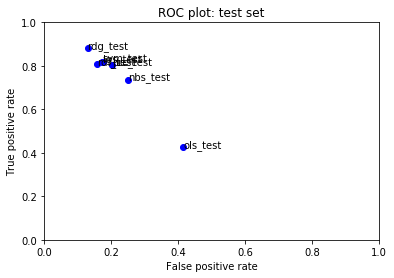

In [56]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [4]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

NameError: name 'process_raw_data' is not defined

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation